First lets import some important packages such as numpy, viresclient, and asilib which wraps the trex/themis/and rego image loaders

In [2]:
import matplotlib.pyplot as plt

import numpy as np

import asilib
import asilib.asi

from viresclient import set_token
from viresclient import SwarmRequest

from EB import EBplotsNEC #Imports E and B data and backend of GUI

import datetime

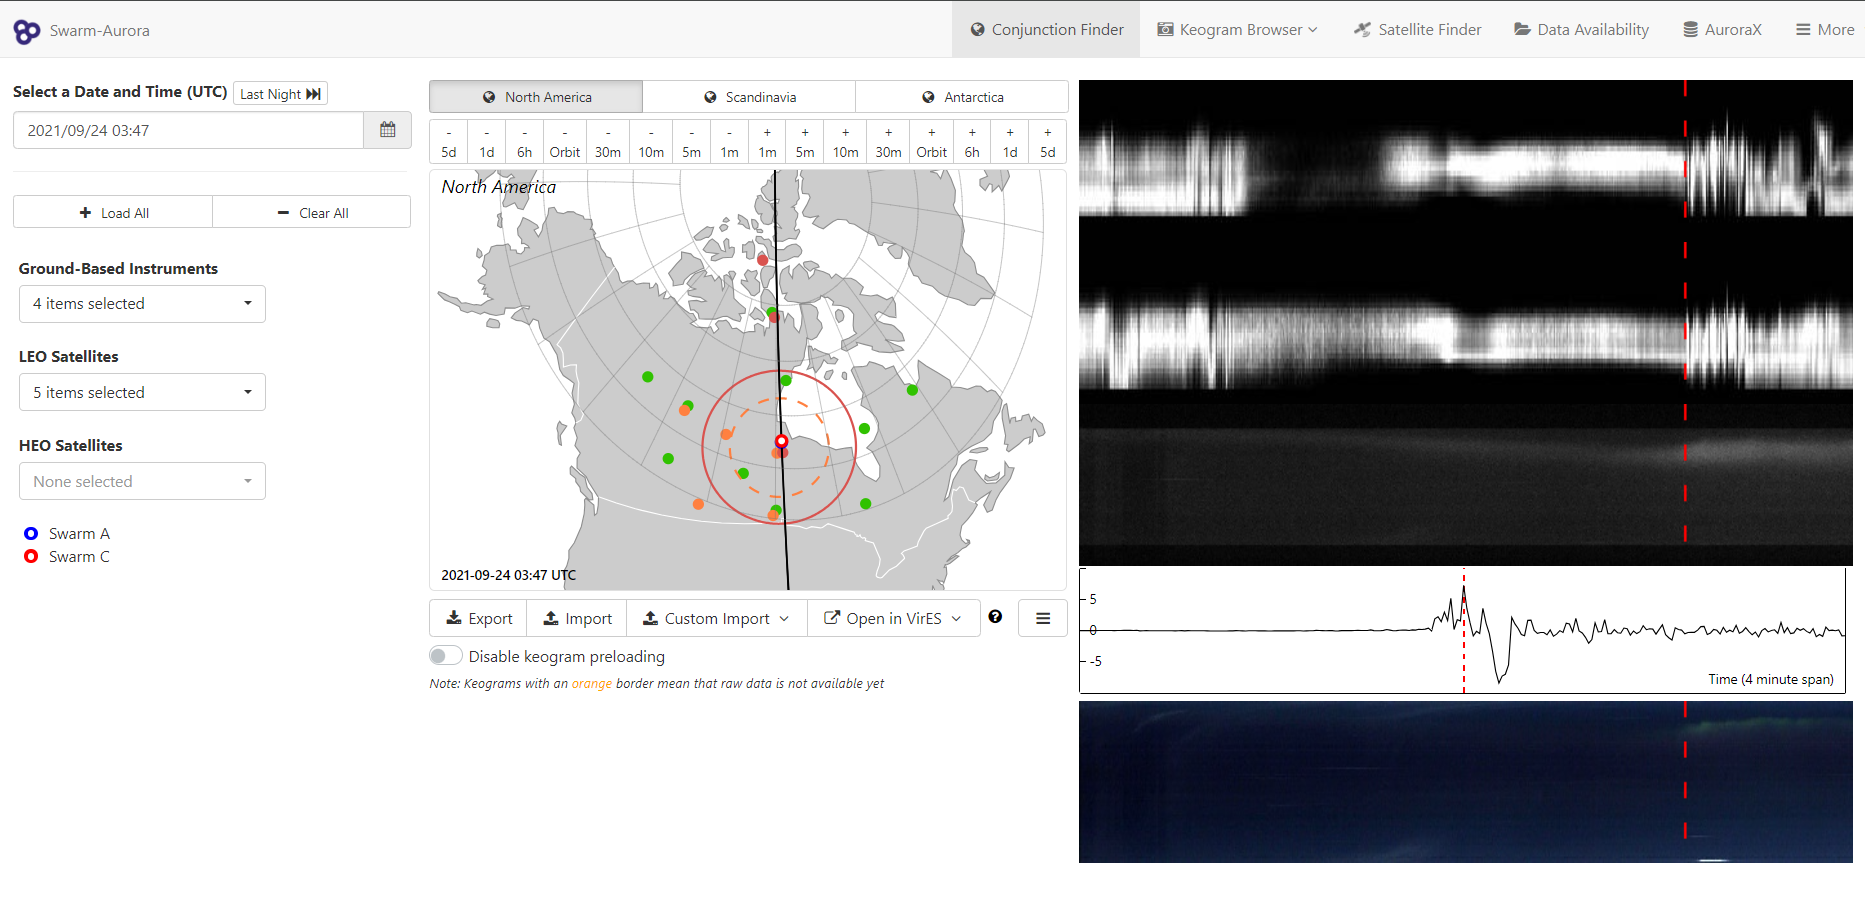

Now lets get the E and B data for this event using my own program

In [3]:
daterange=(datetime.datetime(2021, 9, 24, 3, 46), datetime.datetime(2021, 9, 24, 3, 48))
dict={'time_range': daterange,
       'satellite_graph': ['swarma', 'swarmc'], 'coordinate_system': ['North East Centre'], 'graph_B_chosen': ['East'],
         'B_frequency': ['50Hz'], 'E_frequency': ['16Hz'], 'graph_E_chosen': ['North'], 'graph_PF_chosen': None, 'FAC': False,
           'Difference': False, 'E_B_ratio': None, 'Pixel_intensity': False, 'sky_map_values': None, 'bandpass': [False], 'heatmap': None, #All False from here, these are for further functionaility 
             'conductivities': None, 'animation': False, 'Time_Series': None, 'E_periodogram': None, 'B_periodogram': None, 'EB_periodogram': None,
               'sampling_rate': None, 'window_length': None, 'EB_cross power': None, 'EB_cross phase': None, 'lags_cross': None, 'nperseg': None,
                 'lag': False, 'time_range_single':None,
                   'singles_graph': None, 'pixel_average': None, "E_difference":None, "B_difference": None, "PF_difference": None}

Token saved for https://vires.services/ows
{'time_range': (datetime.datetime(2021, 9, 24, 3, 46), datetime.datetime(2021, 9, 24, 3, 48)), 'satellite_graph': ['swarma', 'swarmc'], 'coordinate_system': ['North East Centre'], 'graph_B_chosen': ['East'], 'B_frequency': ['50Hz'], 'E_frequency': ['16Hz'], 'graph_E_chosen': ['North'], 'graph_PF_chosen': None, 'FAC': False, 'Difference': False, 'E_B_ratio': None, 'Pixel_intensity': False, 'sky_map_values': None, 'bandpass': [False], 'heatmap': None, 'conductivities': None, 'animation': False, 'Time_Series': None, 'E_periodogram': None, 'B_periodogram': None, 'EB_periodogram': None, 'sampling_rate': None, 'window_length': None, 'EB_cross power': None, 'EB_cross phase': None, 'lags_cross': None, 'nperseg': None, 'lag': False, 'time_range_single': None, 'singles_graph': None, 'pixel_average': None, 'E_difference': None, 'B_difference': None, 'PF_difference': None}
dict_keys(['time_range', 'satellite_graph', 'coordinate_system', 'graph_B_chosen', 

<ipython-input-4-509613c1bd7b>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


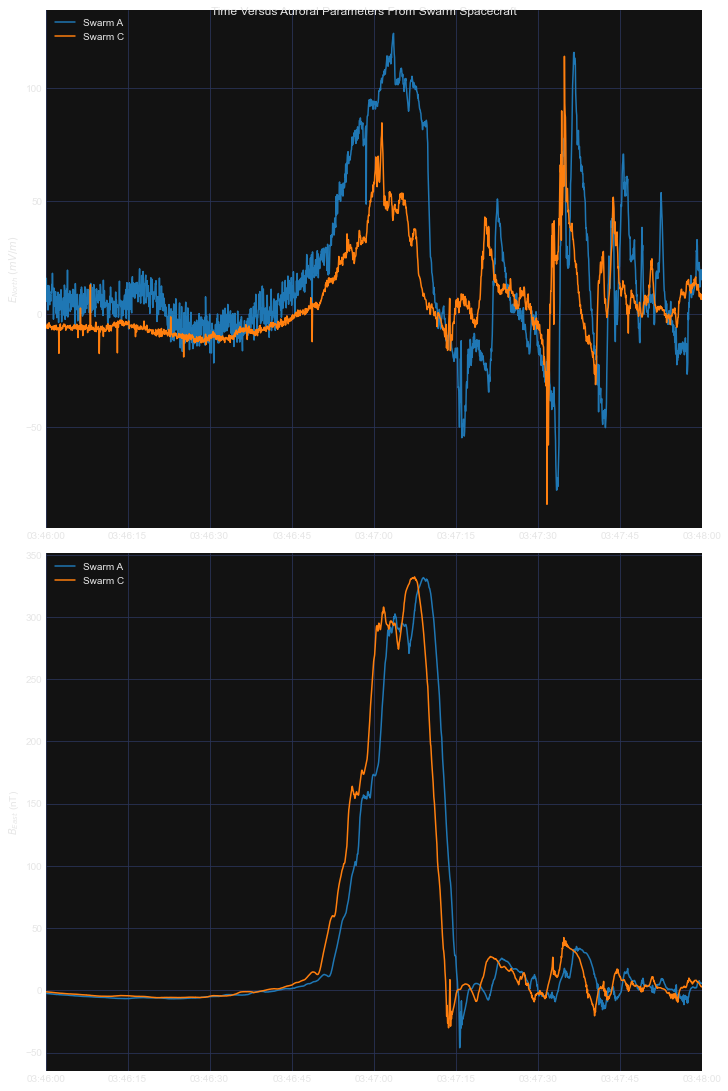

In [4]:
fig,axes,data = EBplotsNEC(dict)
fig.show()

Good we can see a nice  upward field aligned current $dB = +$ at 3:47:12


Lets now dig into the imaging and some of the data

In [5]:
alt=110

False woweeeee
20210924_034600_034800_trex_rgb_gill_110km_fisheye.mp4: |############## | 95%
Animation saved to C:\Users\1101w\asilib-data\animations\20210924_034600_034800_trex_rgb_gill_110km_fisheye.mp4


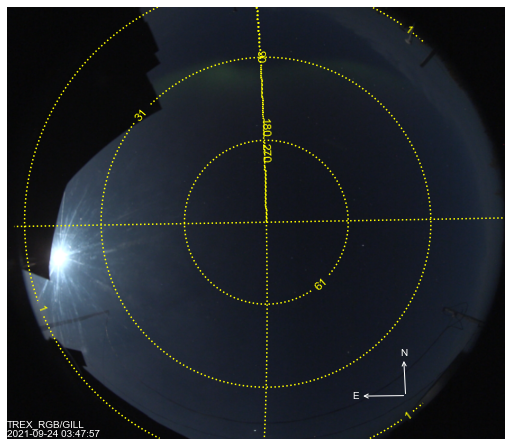

In [6]:
fig, ax = plt.subplots(
    1, 1, figsize=(7, 10), constrained_layout=True
)
asi = asilib.asi.trex_rgb('gill', time_range=daterange, alt=alt)
gen = asi.animate_fisheye(
    ax=ax, azel_contours=True, overwrite=True, cardinal_directions='NE'
)

In [7]:

from IPython.display import Video

Video(r"C:\Users\1101w\asilib-data\animations\20210924_034600_034800_trex_rgb_gill_110km_fisheye.mp4", embed=True)

In [8]:
def calculate_slope(A, B, alt1, alt2): # For skymap Interpolation
    # Calculate the slope matrix
    print(np.shape(B), np.shape(alt1))
    return (B - A) / (alt2 - alt1)

def interpolate_matrix(A, slopes, alt1, alt): #For sky map Interpolation
    # Interpolate or extrapolate to find the matrix at time t
    return A + slopes * (alt - alt1)

Now we want to check the mapping quality! Ideally, for the redline emission we want to line up the $dB$ to the pixel intensity peak so we should first guess 190km and refine from there. This uses two offical skymaps and interpolates between the two, below is the implementation in asilib.

In [9]:
_skymap=asilib.asi.trex_rgb_skymap('gill', time=daterange[0])
print(_skymap['FULL_MAP_ALTITUDE'] / 1e3)
interp_lat = calculate_slope(_skymap['FULL_MAP_LATITUDE'][0, :, :], _skymap['FULL_MAP_LATITUDE'][1, :, :], _skymap['FULL_MAP_ALTITUDE'][0] / 1e3, _skymap['FULL_MAP_ALTITUDE'][1] / 1e3)  #Gets the first and second sky map, figures out the slope matrix between the two
interp_lon = calculate_slope(_skymap['FULL_MAP_LONGITUDE'][0, :, :], _skymap['FULL_MAP_LONGITUDE'][1, :, :], _skymap['FULL_MAP_ALTITUDE'][0] / 1e3 , _skymap['FULL_MAP_ALTITUDE'][1] / 1e3)  
lat = interpolate_matrix(_skymap['FULL_MAP_LATITUDE'][0, :, :], interp_lat,  _skymap['FULL_MAP_ALTITUDE'][0] / 1e3, alt) #Uses the first sky map and the slope matrix to find the skymap at the desired output
lon = interpolate_matrix(_skymap['FULL_MAP_LONGITUDE'][0, :, :], interp_lon,  _skymap['FULL_MAP_ALTITUDE'][0] / 1e3, alt)


[ 90. 110. 150.]
(481, 554) ()
(481, 554) ()


Additionally, asilib has borrows a function from a different ASI (TODO)
```
from typing import Tuple

import numpy as np

import pymap3d


Re = 6378.14  # km

def geodetic_skymap(
        imager_lla:Tuple[float],
        az_skymap:np.ndarray, 
        el_skymap:np.ndarray, 
        alt:float
        ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Project each pixel's (az, el) coordinates to geodetic (lat, lon) coordinates at an emission
    altitude using a spherical earth model.

    Parameters
    ----------
    imager_lla:tuple
        The imager's latitude, longitude, and altitude in km.
    az_skymap:np.ndarray 
        A 2d array of pixel azimuths. 
    el_skymap:np.ndarray 
        A 2d array of pixel elevations.
    alt:float
        Auroral emission altitude in km to map to.

    Returns
    -------
    np.ndarray
        The latitude skymap.
    np.ndarray
        The longitude skymap.
    """
    lat_skymap = np.zeros_like(az_skymap)
    lon_skymap = np.zeros_like(az_skymap)
    _alts = np.zeros_like(az_skymap)

    el_skymap[el_skymap <= 0] = np.nan

    # Range from observer to target assuming Earth is spherical, i.e. not an ellipsoid.
    # https://github.com/space-physics/dascasi/blob/4d72aa91e471a495566044c3fc387344dd12461f/src/dascasi/io.py#L107C32-L107C32
    _el_rad = np.deg2rad(el_skymap)
    _range = np.sqrt(
        (Re+alt)**2 +
        (Re+imager_lla[-1])**2 - 
        2*(Re+alt)*(Re+imager_lla[-1])*np.sin(
            _el_rad + np.arcsin((Re+imager_lla[-1])/(Re+alt)*np.cos(_el_rad))
            )
        )

    for row in range(az_skymap.shape[0]):
        for col in range(az_skymap.shape[1]):
            # Based on Michael Hirsh's (scivision) dascasi package.
            lat_skymap[row, col], lon_skymap[row, col], _alts[row, col] = pymap3d.aer2geodetic(
                az_skymap[row, col],
                el_skymap[row, col],
                _range[row, col] * 1e3,
                *imager_lla[:2], 
                1E3*imager_lla[-1],
                deg=True,
            )
    return lat_skymap, lon_skymap

```

For this date, given an altitude of 190km for a rego image, these are the two images produced where the x is latitude, y is longitude and the color is difference in latitude #Maybe do quadratures?. Differences are most apparent in the edges.

False woweeeee
False woweeeee
False woweeeee
<class 'numpy.ndarray'> type of c
<class 'numpy.ndarray'> type of c
<class 'numpy.ndarray'> type of c


c:\Users\1101w\anaconda3\lib\site-packages\asilib\imager.py:1928: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p = ax.pcolormesh(


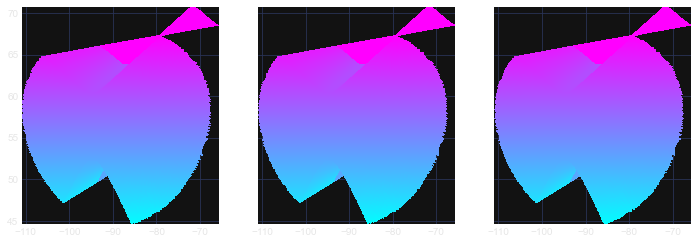

In [10]:
official_asi = asilib.asi.trex_rgb('GILL', time=daterange[0], load_images=False, alt=90)
geodetic_asi = asilib.asi.trex_rgb('GILL', time=daterange[0], load_images=False, alt=110 )
interp_asi = asilib.asi.trex_rgb('GILL', time=daterange[0], load_images=False, alt=150 )
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12, 4))
official_asi._pcolormesh_nan(asi.skymap['lon'], asi.skymap['lat'], asi.skymap['lat'], ax[0])
geodetic_asi._pcolormesh_nan(geodetic_asi.skymap['lon'], geodetic_asi.skymap['lat'], geodetic_asi.skymap['lat'], ax[1])
interp_asi._pcolormesh_nan(geodetic_asi.skymap['lon'], geodetic_asi.skymap['lat'], geodetic_asi.skymap['lat'], ax[2])

False woweeeee
geodetic woweeeee
interp woweeeee
(481, 554) ()
(481, 554) ()
<class 'numpy.ndarray'> type of c
<class 'numpy.ndarray'> type of c
<class 'numpy.ndarray'> type of c


c:\Users\1101w\anaconda3\lib\site-packages\asilib\imager.py:1928: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p = ax.pcolormesh(


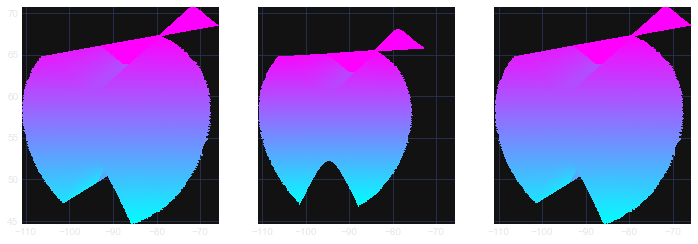

In [11]:
official_asi = asilib.asi.trex_rgb('GILL', time=daterange[0], load_images=False, alt=110)
geodetic_asi = asilib.asi.trex_rgb('GILL', time=daterange[0], load_images=False, custom_alt='geodetic', alt=110 )
interp_asi = asilib.asi.trex_rgb('GILL', time=daterange[0], load_images=False, custom_alt='interp', alt=110 )
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12, 4))
official_asi._pcolormesh_nan(official_asi.skymap['lon'], official_asi.skymap['lat'], official_asi.skymap['lat'], ax[0])
geodetic_asi._pcolormesh_nan(geodetic_asi.skymap['lon'], geodetic_asi.skymap['lat'], geodetic_asi.skymap['lat'], ax[1])
interp_asi._pcolormesh_nan(interp_asi.skymap['lon'], interp_asi.skymap['lat'], interp_asi.skymap['lat'], ax[2])


Now lets go look at some other events

In [12]:
daterange=(datetime.datetime(2020, 3, 29, 7, 38), datetime.datetime(2020, 3, 29, 7, 40))

20200329_073800_074000_themis_inuv_110km_fisheye.mp4: |################ | 95%
Animation saved to C:\Users\1101w\asilib-data\animations\20200329_073800_074000_themis_inuv_110km_fisheye.mp4


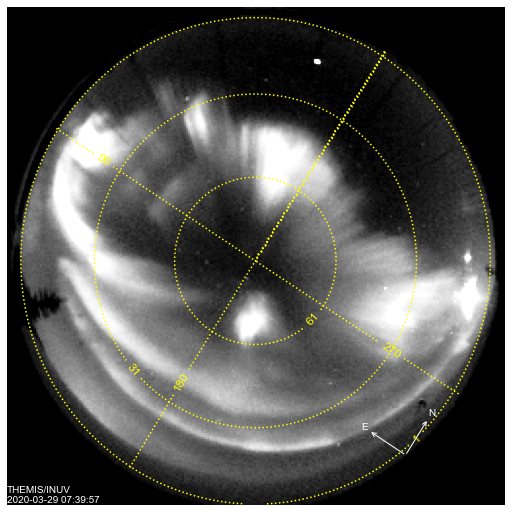

In [13]:
fig, ax = plt.subplots(
    1, 1, figsize=(7, 10), constrained_layout=True
)
asi = asilib.asi.themis('inuv', time_range=daterange, alt=alt)
gen = asi.animate_fisheye(
    ax=ax, azel_contours=True, overwrite=True, cardinal_directions='NE'
)


In [14]:
Video(r"C:\Users\1101w\asilib-data\animations\20200329_073800_074000_themis_inuv_110km_fisheye.mp4", embed=True)

(257, 257) ()
(257, 257) ()
<class 'numpy.ndarray'> type of c
<class 'numpy.ndarray'> type of c
<class 'numpy.ndarray'> type of c


c:\Users\1101w\anaconda3\lib\site-packages\asilib\imager.py:1928: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p = ax.pcolormesh(


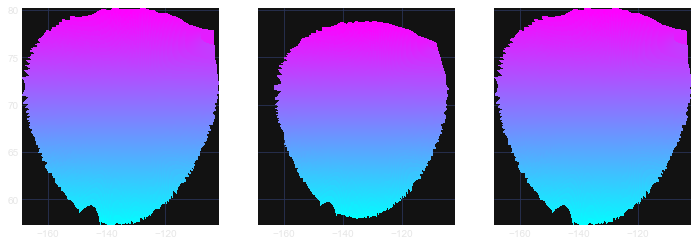

In [15]:
official_asi = asilib.asi.themis('inuv', time=daterange[0], load_images=False, alt=110)
geodetic_asi = asilib.asi.themis('inuv', time=daterange[0], load_images=False, custom_alt='geodetic', alt=110 )
interp_asi = asilib.asi.themis('inuv', time=daterange[0], load_images=False, custom_alt='interp', alt=110 )
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12, 4))
official_asi._pcolormesh_nan(official_asi.skymap['lon'], official_asi.skymap['lat'], official_asi.skymap['lat'], ax[0])
geodetic_asi._pcolormesh_nan(geodetic_asi.skymap['lon'], geodetic_asi.skymap['lat'], geodetic_asi.skymap['lat'], ax[1])
interp_asi._pcolormesh_nan(interp_asi.skymap['lon'], interp_asi.skymap['lat'], interp_asi.skymap['lat'], ax[2])


In [16]:
daterange=(datetime.datetime(2020, 1, 14, 11, 24), datetime.datetime(2020, 1, 14, 11, 28))

20200114_112400_112800_rego_rank_230km_fisheye.mp4: |################## | 98%
Animation saved to C:\Users\1101w\asilib-data\animations\20200114_112400_112800_rego_rank_230km_fisheye.mp4
20200114_112400_112800_rego_talo_230km_fisheye.mp4: |################## | 98%
Animation saved to C:\Users\1101w\asilib-data\animations\20200114_112400_112800_rego_talo_230km_fisheye.mp4


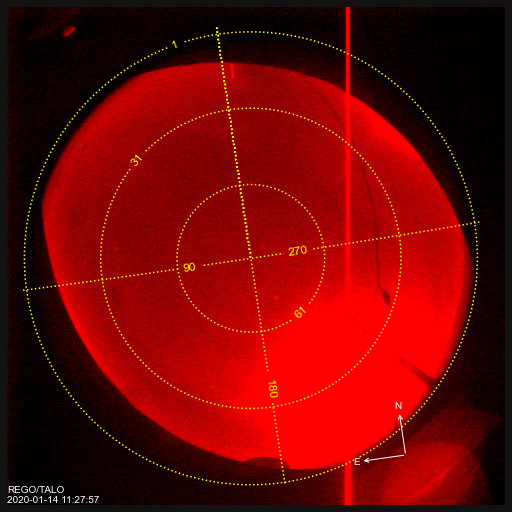

In [24]:
fig, ax = plt.subplots(
    1, 1, figsize=(7, 10), constrained_layout=True
)
asi = asilib.asi.rego('rank', time_range=daterange, alt=230)
gen = asi.animate_fisheye(
    ax=ax, azel_contours=True, overwrite=True, cardinal_directions='NE', color_bounds=[300,500]
)
asi = asilib.asi.rego('talo', time_range=daterange, alt=230)
gen = asi.animate_fisheye(
    ax=ax, azel_contours=True, overwrite=True, cardinal_directions='NE', color_bounds=[300,500]
)



In [25]:
from moviepy.editor import VideoFileClip, concatenate_videoclips, clips_array
combined = clips_array([[VideoFileClip(r"C:\Users\1101w\asilib-data\animations\20200114_112400_112800_rego_rank_230km_fisheye.mp4"), VideoFileClip(r"C:\Users\1101w\asilib-data\animations\20200114_112400_112800_rego_talo_230km_fisheye.mp4")]])
combined.write_videofile("animation_display.mp4")
Video("animation_display.mp4",  embed=True)

Moviepy - Building video animation_display.mp4.
Moviepy - Writing video animation_display.mp4



Moviepy - Done !
Moviepy - video ready animation_display.mp4


In [26]:
dict={'time_range': daterange,
       'satellite_graph': ['swarma', 'swarmc'], 'coordinate_system': ['North East Centre'], 'graph_B_chosen': ['East'],
         'B_frequency': ['50Hz'], 'E_frequency': ['16Hz'], 'graph_E_chosen': ['North'], 'graph_PF_chosen': None, 'FAC': False,
           'Difference': False, 'E_B_ratio': None, 'Pixel_intensity': False, 'sky_map_values': None, 'bandpass': [False], 'heatmap': None, #All False from here, these are for further functionaility 
             'conductivities': None, 'animation': False, 'Time_Series': None, 'E_periodogram': None, 'B_periodogram': None, 'EB_periodogram': None,
               'sampling_rate': None, 'window_length': None, 'EB_cross power': None, 'EB_cross phase': None, 'lags_cross': None, 'nperseg': None,
                 'lag': False, 'time_range_single':None,
                   'singles_graph': None, 'pixel_average': None, "E_difference":None, "B_difference": None, "PF_difference": None}

Token saved for https://vires.services/ows
{'time_range': (datetime.datetime(2020, 1, 14, 11, 24), datetime.datetime(2020, 1, 14, 11, 28)), 'satellite_graph': ['swarma', 'swarmc'], 'coordinate_system': ['North East Centre'], 'graph_B_chosen': ['East'], 'B_frequency': ['50Hz'], 'E_frequency': ['16Hz'], 'graph_E_chosen': ['North'], 'graph_PF_chosen': None, 'FAC': False, 'Difference': False, 'E_B_ratio': None, 'Pixel_intensity': False, 'sky_map_values': None, 'bandpass': [False], 'heatmap': None, 'conductivities': None, 'animation': False, 'Time_Series': None, 'E_periodogram': None, 'B_periodogram': None, 'EB_periodogram': None, 'sampling_rate': None, 'window_length': None, 'EB_cross power': None, 'EB_cross phase': None, 'lags_cross': None, 'nperseg': None, 'lag': False, 'time_range_single': None, 'singles_graph': None, 'pixel_average': None, 'E_difference': None, 'B_difference': None, 'PF_difference': None}
dict_keys(['time_range', 'satellite_graph', 'coordinate_system', 'graph_B_chosen'

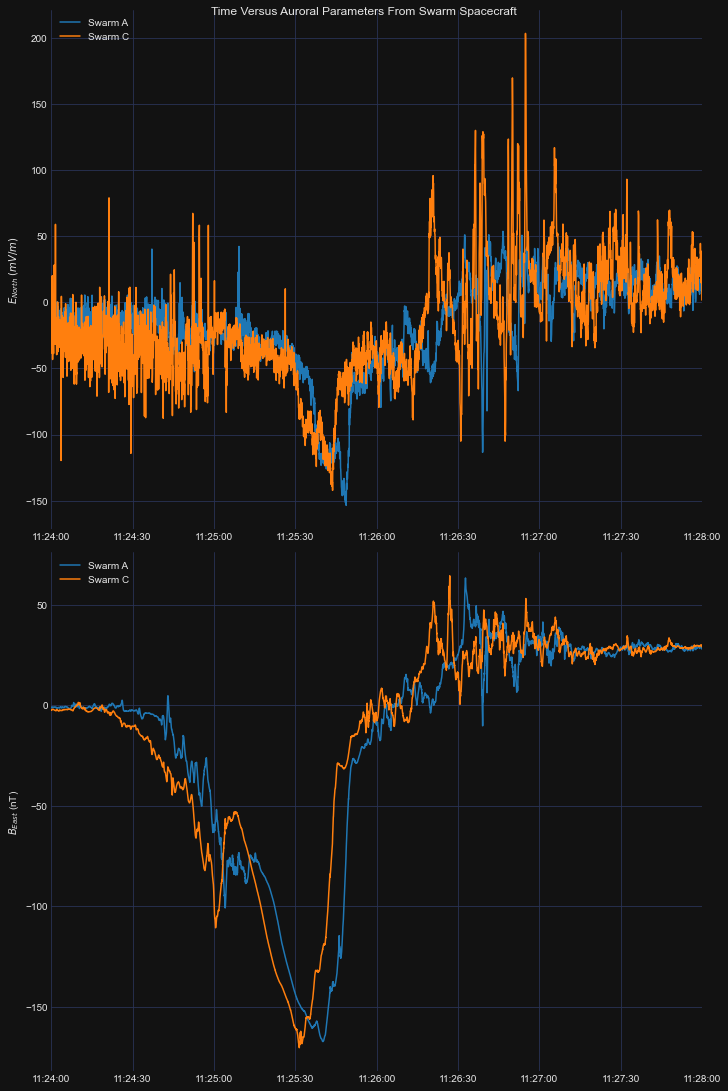

In [27]:
fig,axes,data = EBplotsNEC(dict)
fig.show()

Any way to get full rid of full moon as Magnetic and Electric data are very interesting!  https://arxiv.org/abs/2205.10882

<class 'numpy.ndarray'> type of c
<class 'numpy.ndarray'> type of c
<class 'numpy.ndarray'> type of c


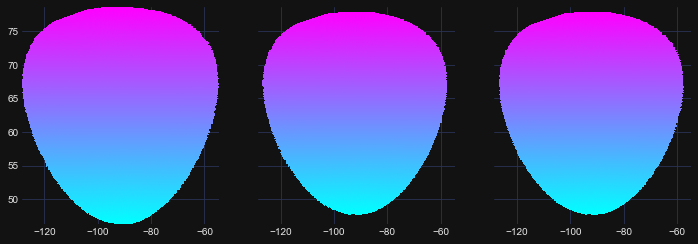

In [28]:
official_asi = asilib.asi.rego('rank', time=daterange[0], load_images=False, alt=230)
geodetic_asi = asilib.asi.rego('rank', time=daterange[0], load_images=False, custom_alt='geodetic', alt=230 )
interp_asi = asilib.asi.rego('rank', time=daterange[0], load_images=False, custom_alt='interp', alt=230 )
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12, 4))
official_asi._pcolormesh_nan(official_asi.skymap['lon'], official_asi.skymap['lat'], official_asi.skymap['lat'], ax[0])
geodetic_asi._pcolormesh_nan(geodetic_asi.skymap['lon'], geodetic_asi.skymap['lat'], geodetic_asi.skymap['lat'], ax[1])
interp_asi._pcolormesh_nan(interp_asi.skymap['lon'], interp_asi.skymap['lat'], interp_asi.skymap['lat'], ax[2])


Why are the rego skymap interpolation and official different?

<class 'numpy.ndarray'> type of c
<class 'numpy.ndarray'> type of c
<class 'numpy.ndarray'> type of c


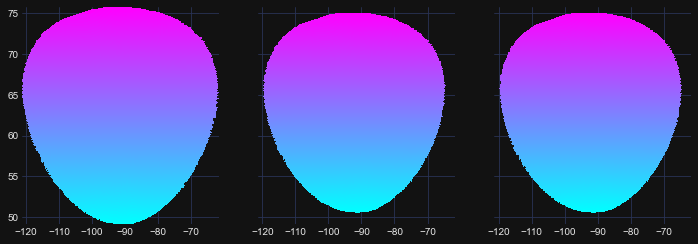

In [30]:
official_asi = asilib.asi.rego('rank', time=daterange[0], load_images=False, alt=150)
geodetic_asi = asilib.asi.rego('rank', time=daterange[0], load_images=False, custom_alt='geodetic', alt=150)
interp_asi = asilib.asi.rego('rank', time=daterange[0], load_images=False, custom_alt='interp', alt=150 )
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12, 4))
official_asi._pcolormesh_nan(official_asi.skymap['lon'], official_asi.skymap['lat'], official_asi.skymap['lat'], ax[0])
geodetic_asi._pcolormesh_nan(geodetic_asi.skymap['lon'], geodetic_asi.skymap['lat'], geodetic_asi.skymap['lat'], ax[1])
interp_asi._pcolormesh_nan(interp_asi.skymap['lon'], interp_asi.skymap['lat'], interp_asi.skymap['lat'], ax[2])

<class 'numpy.ndarray'> type of c
<class 'numpy.ndarray'> type of c
<class 'numpy.ndarray'> type of c


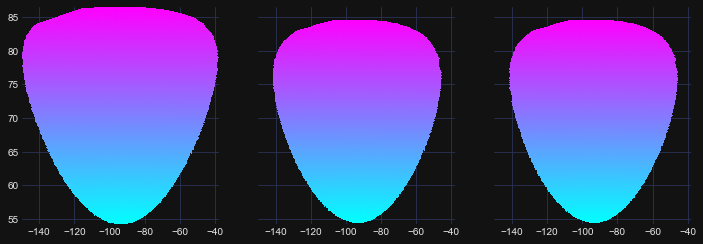

In [31]:
official_asi = asilib.asi.rego('talo', time=daterange[0], load_images=False, alt=230)
geodetic_asi = asilib.asi.rego('talo', time=daterange[0], load_images=False, custom_alt='geodetic', alt=230 )
interp_asi = asilib.asi.rego('talo', time=daterange[0], load_images=False, custom_alt='interp', alt=230 )
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12, 4))
official_asi._pcolormesh_nan(official_asi.skymap['lon'], official_asi.skymap['lat'], official_asi.skymap['lat'], ax[0])
geodetic_asi._pcolormesh_nan(geodetic_asi.skymap['lon'], geodetic_asi.skymap['lat'], geodetic_asi.skymap['lat'], ax[1])
interp_asi._pcolormesh_nan(interp_asi.skymap['lon'], interp_asi.skymap['lat'], interp_asi.skymap['lat'], ax[2])


In [32]:
daterange=(datetime.datetime(2021, 4, 16, 6, 38), datetime.datetime(2021, 4, 16, 6, 42))
alt=110

False woweeeee
20210416_063800_064200_trex_rgb_fsmi_110km_fisheye.mp4: |############## | 98%
Animation saved to C:\Users\1101w\asilib-data\animations\20210416_063800_064200_trex_rgb_fsmi_110km_fisheye.mp4


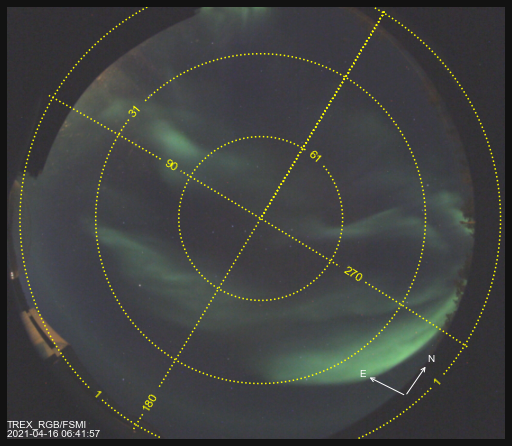

In [35]:
fig, ax = plt.subplots(
    1, 1, figsize=(7, 10), constrained_layout=True
)
asi = asilib.asi.trex_rgb('fsmi', time_range=daterange, alt=alt)
gen = asi.animate_fisheye(
    ax=ax, azel_contours=True, overwrite=True, cardinal_directions='NE'
)

In [39]:
Video(r"C:\Users\1101w\asilib-data\animations\20210416_063800_064200_trex_rgb_fsmi_110km_fisheye.mp4", embed=True)

False woweeeee
geodetic woweeeee
interp woweeeee
(481, 554) ()
(481, 554) ()
<class 'numpy.ndarray'> type of c
<class 'numpy.ndarray'> type of c
<class 'numpy.ndarray'> type of c


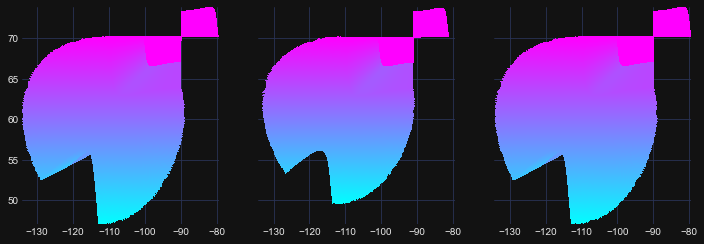

In [40]:
official_asi = asilib.asi.trex_rgb('fsmi', time=daterange[0], load_images=False, alt=110)
geodetic_asi = asilib.asi.trex_rgb('fsmi', time=daterange[0], load_images=False, custom_alt='geodetic', alt=110 )
interp_asi = asilib.asi.trex_rgb('fsmi', time=daterange[0], load_images=False, custom_alt='interp', alt=110 )
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12, 4))
official_asi._pcolormesh_nan(official_asi.skymap['lon'], official_asi.skymap['lat'], official_asi.skymap['lat'], ax[0])
geodetic_asi._pcolormesh_nan(geodetic_asi.skymap['lon'], geodetic_asi.skymap['lat'], geodetic_asi.skymap['lat'], ax[1])
interp_asi._pcolormesh_nan(interp_asi.skymap['lon'], interp_asi.skymap['lat'], interp_asi.skymap['lat'], ax[2])

In [42]:
daterange=(datetime.datetime(2022, 12, 19, 14, 4), datetime.datetime(2022, 12, 19, 14, 6))
alt=110

False woweeeee
20221219_140400_140600_trex_rgb_yknf_110km_fisheye.mp4: |############## | 95%
Animation saved to C:\Users\1101w\asilib-data\animations\20221219_140400_140600_trex_rgb_yknf_110km_fisheye.mp4


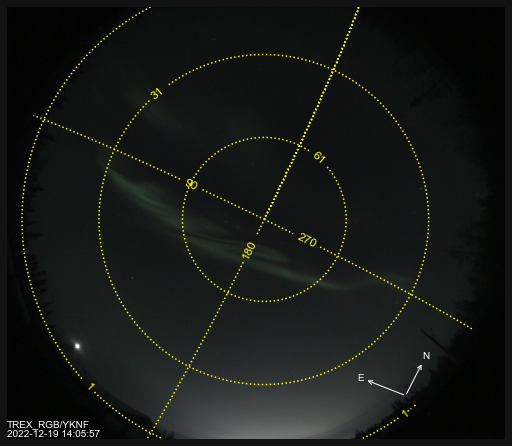

In [43]:
fig, ax = plt.subplots(
    1, 1, figsize=(7, 10), constrained_layout=True
)
asi = asilib.asi.trex_rgb('yknf', time_range=daterange, alt=alt)
gen = asi.animate_fisheye(
    ax=ax, azel_contours=True, overwrite=True, cardinal_directions='NE'
)

In [44]:
Video(r"C:\Users\1101w\asilib-data\animations\20221219_140400_140600_trex_rgb_yknf_110km_fisheye.mp4", embed=True)

False woweeeee
geodetic woweeeee
interp woweeeee
(481, 554) ()
(481, 554) ()
<class 'numpy.ndarray'> type of c
<class 'numpy.ndarray'> type of c
<class 'numpy.ndarray'> type of c


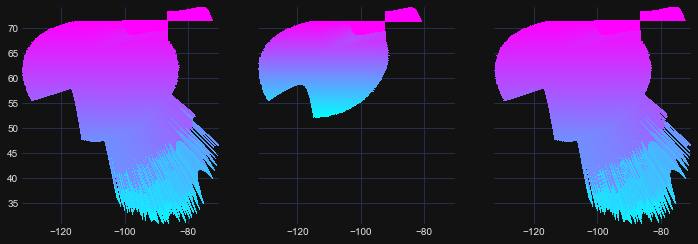

: 

In [45]:
official_asi = asilib.asi.trex_rgb('yknf', time=daterange[0], load_images=False, alt=110)
geodetic_asi = asilib.asi.trex_rgb('yknf', time=daterange[0], load_images=False, custom_alt='geodetic', alt=110 )
interp_asi = asilib.asi.trex_rgb('yknf', time=daterange[0], load_images=False, custom_alt='interp', alt=110 )
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12, 4))
official_asi._pcolormesh_nan(official_asi.skymap['lon'], official_asi.skymap['lat'], official_asi.skymap['lat'], ax[0])
geodetic_asi._pcolormesh_nan(geodetic_asi.skymap['lon'], geodetic_asi.skymap['lat'], geodetic_asi.skymap['lat'], ax[1])
interp_asi._pcolormesh_nan(interp_asi.skymap['lon'], interp_asi.skymap['lat'], interp_asi.skymap['lat'], ax[2])